In [27]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

In [33]:
face_cascade = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')

In [34]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None
    
    x,y,w,h = faces[0]
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    return face

In [35]:
train_dir = '../datasets/CK_dataset/train'
test_dir = '../datasets/CK_dataset/test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
efficientnet_b0_model = models.efficientnet_b0(pretrained=True)
num_features = efficientnet_b0_model.classifier[1].in_features
efficientnet_b0_model.classifier[1] = nn.Linear(num_features, 6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_b0_model.parameters(), lr=0.0001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficientnet_b0_model.to(device)

C:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [37]:
num_epochs = 25
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    efficientnet_b0_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = efficientnet_b0_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_accuracy = 100 * correct / total
    train_acc_list.append(train_accuracy)
    train_loss_list.append(running_loss / len(train_loader))
    
    efficientnet_b0_model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_b0_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss / len(test_loader))
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
        f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%'
    )

Epoch [1/25], Loss: 1.7429, Train Accuracy: 26.39%, Test Accuracy: 35.66%
Epoch [2/25], Loss: 1.4648, Train Accuracy: 60.12%, Test Accuracy: 47.55%
Epoch [3/25], Loss: 1.2061, Train Accuracy: 70.09%, Test Accuracy: 56.64%
Epoch [4/25], Loss: 1.0004, Train Accuracy: 72.14%, Test Accuracy: 59.44%
Epoch [5/25], Loss: 0.8331, Train Accuracy: 77.13%, Test Accuracy: 60.14%
Epoch [6/25], Loss: 0.7078, Train Accuracy: 80.35%, Test Accuracy: 60.84%
Epoch [7/25], Loss: 0.6420, Train Accuracy: 84.46%, Test Accuracy: 65.03%
Epoch [8/25], Loss: 0.5395, Train Accuracy: 85.63%, Test Accuracy: 62.94%
Epoch [9/25], Loss: 0.4472, Train Accuracy: 91.79%, Test Accuracy: 64.34%
Epoch [10/25], Loss: 0.3587, Train Accuracy: 92.96%, Test Accuracy: 64.34%
Epoch [11/25], Loss: 0.3271, Train Accuracy: 92.96%, Test Accuracy: 62.24%
Epoch [12/25], Loss: 0.3080, Train Accuracy: 92.67%, Test Accuracy: 63.64%
Epoch [13/25], Loss: 0.2397, Train Accuracy: 95.01%, Test Accuracy: 65.03%
Epoch [14/25], Loss: 0.2003, Train

Final Test Accuracy: 62.94%


<Figure size 800x600 with 0 Axes>

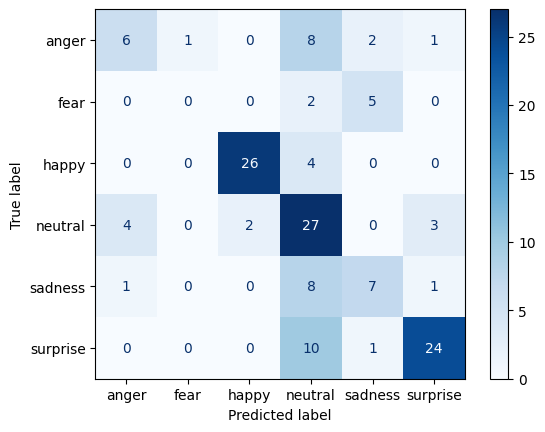

In [38]:
# Final Evaluation and Confusion Matrix
efficientnet_b0_model.eval()
y_true = []
y_pred = []
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_b0_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_test_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=test_dataset.classes)

plt.figure(figsize=(8,6))
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

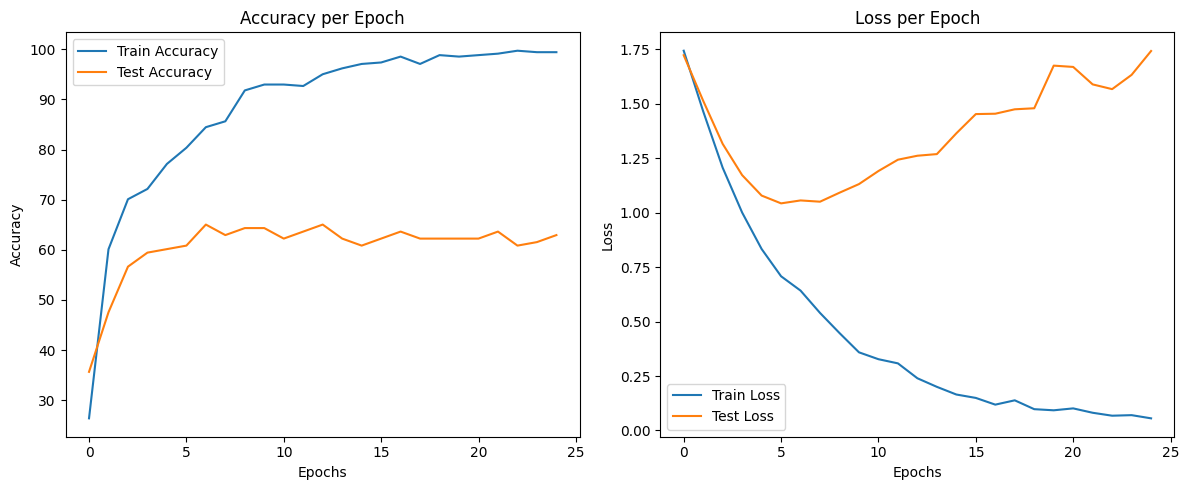

In [39]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

plt.subplot(1,2,2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.tight_layout()
plt.show()

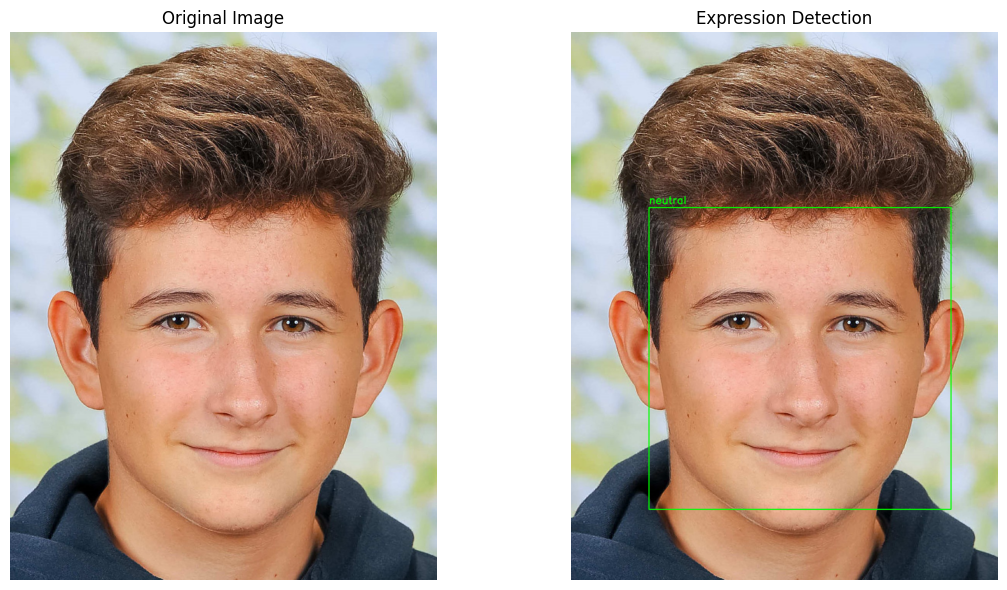

In [64]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None
    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    return face

def predict_expression(image, model, device):
    face = detect_face(image)
    if face is None:
        return None, None
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    face_tensor = transform(face).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(face_tensor)
        _, predicted = torch.max(outputs, 1)
    emotion = train_dataset.classes[predicted.item()]
    return emotion, face

def draw_faces_and_predictions(image, model, device):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        print("No faces detected.")
        return image
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        emotion, _ = predict_expression(face, model, device)
        if emotion:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def test_single_image_multiple_faces(image_path, model, device):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
    image_copy = image.copy()
    image_with_predictions = draw_faces_and_predictions(image_copy, model, device)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_with_predictions, cv2.COLOR_BGR2RGB))
    plt.title('Expression Detection')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

img_path = '../testimages/me.jpg'
test_single_image_multiple_faces(img_path, efficientnet_b0_model, face_cascade, device)

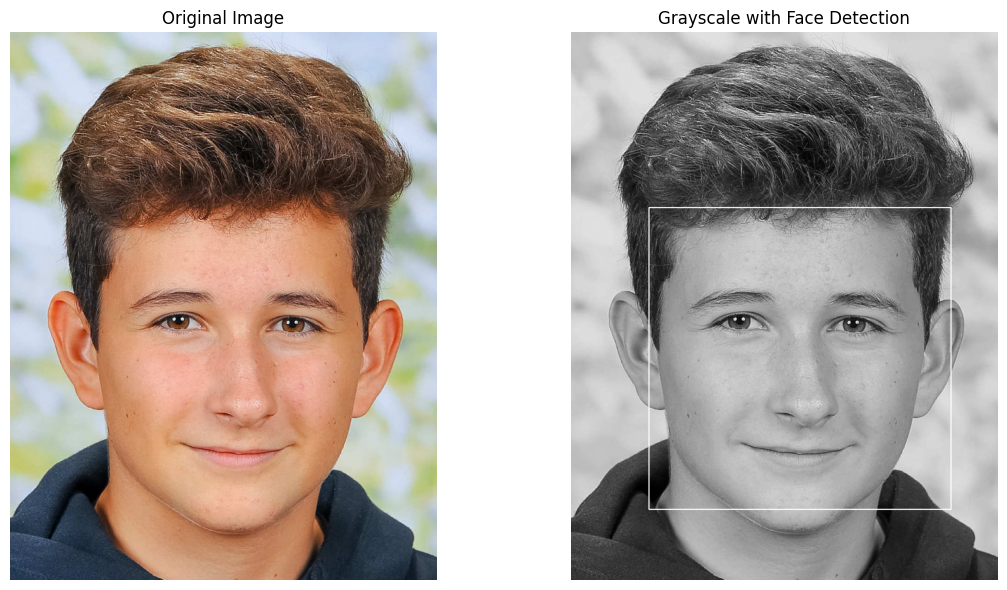

In [61]:
# Present face detection for report
import cv2
import matplotlib.pyplot as plt
import os

def display_grayscale_and_face_detection(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray_image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    image_with_boxes = gray_image.copy()
    if len(faces) == 0:
        print("No faces detected.")
    else:
        for (x, y, w, h) in faces:
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255), 2)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_with_boxes, cmap='gray')
    plt.title('Grayscale with Face Detection')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

img_path = '../testimages/me.jpg'
if not os.path.exists(img_path):
    print(f"Error: Image file {img_path} not found at {os.path.abspath(img_path)}")
else:
    display_grayscale_and_face_detection(img_path)